The first step is to include all the required libraries. These will include all the artificial intelligence libraries that are required for this system to run.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import sklearn.model_selection as sk
import os
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer

<class 'keras.engine.sequential.Sequential'>


Next, we need to read the data set that we will be using to train and test data. This can be found in a particular document and assumes that this python notebook is executed in the correct directory.

In [129]:
raw_training_data = pd.read_csv('../../training/sign_mnist_train.csv')
raw_testing_data = pd.read_csv('../../training/sign_mnist_test.csv')

The data includes a single row per training set. This means if we look at the rows, it shows each image as a column of pixel values (greyscale) between 0 and 255.

In [130]:
raw_training_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


We also need to specify the labels of each image based on the ID code. The labels are associated with each letter. This means there are 26 different combinations for different images based on the symbols being used.

In [131]:
img_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

Time to create the data sets. We need to isolate the raw data with the results from both the training and testing data sets. The validation set needs to be created from the training data which is used to validate each of the set. About 20% of the data should be used for validation. Additionally, with the pixel data, we need to get it between 0 and 1.

In [132]:
# Get the binary data for the labels
label_binarizer = LabelBinarizer()
train_data_result = label_binarizer.fit_transform(raw_training_data['label'])
test_data_result = label_binarizer.fit_transform(raw_testing_data['label'])

# Remove the labels from the data
del raw_training_data['label']
del raw_testing_data['label']

# Get the image data
train_data_image = raw_training_data.values / 255
test_data_image = raw_testing_data.values / 255

# Reshape the image data
train_data_image = train_data_image.reshape(-1,28,28,1)
test_data_image = test_data_image.reshape(-1,28,28,1)

Each of the lines of data in the CSV handles different letters in the form of a 28x28 pixel image. For example, let's look at the first image of the training set:

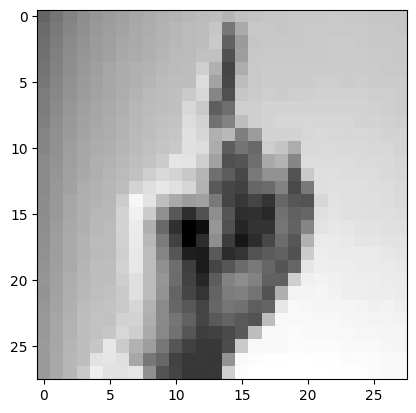

In [133]:
plt.imshow(train_data_image[0].reshape(28, 28) , cmap = "gray")

There are some operating system settings that must be set up to make the kernel work with the neural network. This can be done using the following:

In [134]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

We start by creating the convalutional neural network.

In [135]:
cnn_model = Sequential()

We can modify the CNN for the number of nodes and layers within the network. Playing around with these numbers will result in differences for accuracy and time complexity.

In [136]:
model = Sequential()
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 24 , activation = 'softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_37 (Conv2D)          (None, 28, 28, 75)        750       
                                                                 
 batch_normalization_18 (Bat  (None, 28, 28, 75)       300       
 chNormalization)                                                
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 14, 14, 75)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 14, 14, 50)        33800     
                                                                 
 dropout_19 (Dropout)        (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_19 (Bat  (None, 14, 14, 50)     

We can also create a randomiser, that has random data to avoid overfitting.

In [137]:
# With data augmentation to prevent overfitting
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

# Fit the data
datagen.fit(train_data_image)

Time for the training! This is done with the specified number of epochs and this may take a while to execute.

In [138]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)
history = model.fit(datagen.flow(train_data_image, train_data_result, batch_size = 128), epochs = 5, validation_data = (test_data_image, test_data_result), callbacks = [learning_rate_reduction])

Epoch 1/5
215/215 [==============================] - 49s 223ms/step - loss: 1.0383 - accuracy: 0.6727 - val_loss: 3.5888 - val_accuracy: 0.0931 - lr: 0.0010
Epoch 2/5
215/215 [==============================] - 46s 212ms/step - loss: 0.2042 - accuracy: 0.9334 - val_loss: 1.2341 - val_accuracy: 0.5590 - lr: 0.0010
Epoch 3/5
215/215 [==============================] - 45s 208ms/step - loss: 0.0997 - accuracy: 0.9676 - val_loss: 0.0888 - val_accuracy: 0.9851 - lr: 0.0010
Epoch 4/5
215/215 [==============================] - 45s 209ms/step - loss: 0.0645 - accuracy: 0.9803 - val_loss: 0.0592 - val_accuracy: 0.9813 - lr: 0.0010
Epoch 5/5
215/215 [==============================] - 45s 211ms/step - loss: 0.0469 - accuracy: 0.9857 - val_loss: 0.0388 - val_accuracy: 0.9866 - lr: 0.0010


Now that the model is trained, we can now test with the testing data to ensure that the model is accurate:

In [142]:
print("Accuracy of the model is: %s" % model.evaluate(test_data_image, test_data_result)[1])

225/225 [==============================] - 4s 18ms/step - loss: 0.0388 - accuracy: 0.9866
Accuracy of the model is: 0.9866145849227905


We can now attempt to save the model for later use.

In [140]:
model.save('../../models/sign_model')

INFO:tensorflow:Assets written to: ../../models/sign_model/assets


INFO:tensorflow:Assets written to: ../../models/sign_model/assets


We can also load the model back.

In [1]:
model = keras.models.load_model('../../models/sign_model')

NameError: name 'keras' is not defined